<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/MultilayeredStructuresSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This demo solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) multilayered structures, (2) membrane permeability, (3) pure homogeneous Neumann 

# Copyright (C) 20u_0u_017 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-09

# This demo is maintained by Van-Dang Nguyen
# Please report problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [41]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3



dolfin version: 2018.1.0


#Pre-defined functions

In [0]:
def MyFunctionSpaces(mesh, porder, PeriodicBD=None):
  Ve = FiniteElement("CG", mesh.ufl_cell(), porder)
  TH = MixedElement([Ve,Ve,Ve,Ve])
  if (PeriodicBD==None):
        V = FunctionSpace(mesh,Ve);
        W = FunctionSpace(mesh, TH)
  else:
        print("Initialize peridodic function spaces.")
        V = FunctionSpace(mesh,Ve, constrained_domain=PeriodicBD)
        W = FunctionSpace(mesh, TH, constrained_domain=PeriodicBD)    
  return Ve, V, W

def GdotX(gdir, mesh):
  gdim = mesh.geometry().dim()
  if (gdim==2):
    GX=Expression("x[0]*g0+x[1]*g1", g0=gdir.x(), g1=gdir.y(), domain=mesh, degree=3);
  if (gdim==3):
    GX=Expression("x[0]*g0+x[1]*g1+x[2]*g2", g0=gdir.x(), g1=gdir.y(), g2=gdir.z(), domain=mesh, degree=3);
  return GX;

def Gdir(g0, g1, g2, mesh):
  gdim = mesh.geometry().dim()
  if (gdim==2):
    gdir = Point(g0, g1);
  if (gdim==3):
    gdir = Point(g0, g1, g2);
  return gdir/gdir.norm();

def FuncF_wBC(ft, gnorm, gdir, ur, ui, vr, vi, K):
    GX=GdotX(gdir, mesh)
    Fr = ft*gnorm*GX*ui*vr - inner(K*grad(ur), grad(vr))
    Fi = - ft*gnorm*GX*ur*vi - inner(K*grad(ui), grad(vi))
    return Fr + Fi
  
def icondition_wBC(kappa, u0rm, u1rm, v0r, v1r, u0im, u1im, v0i, v1i):
    F_bcr = kappa*(u0rm-u1rm)*(v0r-v1r)
    F_bci = kappa*(u0im-u1im)*(v0i-v1i)
    return F_bcr + F_bci

def SubMeshSave(ur, ui, file_ur, file_ui, mesh, n, stepcounter, dolfin_version):
  if dolfin_version=='1.6.0':
    V = FunctionSpace(mesh, "CG", porder)
  else:
    # For FEniCS 2016, 2017
    Ve = FiniteElement("CG", mesh.ufl_cell(), porder)
    V = FunctionSpace(mesh, Ve)
  if stepcounter % n == 0:
    ur_p = project(ur, V);
    ui_p = project(ui, V);
    ur_p.rename("Real", "label");
    ui_p.rename("Imag", "label");
    file_ur << ur_p;
    file_ui << ui_p;

def ieval(u,omega, phase):
  if omega==1:
    return u('+')*phase('+') + u('-')*phase('-');
  if omega==0:
    return u('+')*(1.-phase('+')) + u('-')*(1.-phase('-'))                      
  
def time_profile(t, delta, Delta, stype):
  ft1, ft2 = 0, 0;
  if stype=='PGSE':
    ft1 = 1.0*(t>=0 and t<delta) 
    ft2 = -1.0*(t>=Delta and t<=Delta+delta);
  if stype=='cos_OGSE':
    ft1 =  cos(2.0*nperiod*pi*t/delta)*(t>=0 and t<delta);
    ft2 = -cos(2.0*nperiod*pi*(t-2.*delta)/delta)*(t>=Delta and t<=Delta+delta);
  return ft1 + ft2; 

def itime_profile(t, delta, Delta, stype): # integrate ft
    ft1, ft2, ft3 = 0, 0, 0;
    if stype=='PGSE':
      ft1 = t*(t>=0 and t<delta) 
      ft2 = delta*(t>=delta and t<Delta) 
      ft3 = (delta - t + Delta)*(t>=Delta and t<=Delta+delta) 
    return ft1 + ft2 + ft3;  

def ThetaMethodL_wBC1c(ft, ift, mparameters , w , v, u_0 ,k, K, theta, mydomain, wpperiodic):
    gnorm = mparameters.gnorm
    gdir = mparameters.gdir
    u0r_0, u0i_0 = split(u_0)
    v0r, v0i = v[0], v[1]
    u0r, u0i = w[0], w[1]
    L0 = (u0r_0/k*v0r + u0i_0/k*v0i+(1-theta)*FuncF_wBC(ft, gnorm, gdir, u0r_0, u0i_0, v0r, v0i, K))*dx
    L_pbc = 0;
    if (mydomain.PeriodicDir[0]+mydomain.PeriodicDir[1]+mydomain.PeriodicDir[2])>0:
      # Start applying the weak pseudo-periodic BC
      wpperiodic.set_values(u_0, ift);
      u0r_bc, u0i_bc = wpperiodic[0], wpperiodic[1]
      L_pbc +=  (1-theta)*mydomain.kappa_e*(u0r_bc*v0r   + u0i_bc*v0i)*ds; # u0r_0, u0i_0                                                          
      # End of applying the weak pseudo-periodic BC
    return L0+L_pbc

def ThetaMethodF_wBC1c(ft, ift, mparameters, w , v, k, K, theta, mydomain):
    gnorm = mparameters.gnorm
    gdir = mparameters.gdir
    kappa = mydomain.kappa
    v0r, v0i = v[0], v[1]
    u0r, u0i = w[0], w[1]
    a0 = (  -theta*FuncF_wBC(ft, gnorm, gdir, u0r, u0i, v0r, v0i, K))*dx
    a_pbc = 0;
    if (mydomain.PeriodicDir[0]+mydomain.PeriodicDir[1]+mydomain.PeriodicDir[2])>0:
      a_pbc = theta*mydomain.kappa_e*(u0r*v0r   + u0i*v0i)*ds;
    return a0+a_pbc
  
  
def ThetaMethodL_wBC2c(ft, ift, mparameters , w , v, u_0 ,k, K, theta, phase, mydomain, wpperiodic):
    gnorm = mparameters.gnorm
    gdir = mparameters.gdir
    kappa = mydomain.kappa
    u0r_0, u0i_0, u1r_0, u1i_0 = split(u_0)
    v0r, v0i, v1r, v1i = v[0], v[1], v[2], v[3]
    u0r, u0i, u1r, u1i = w[0], w[1], w[2], w[3]

    L0 = (u0r_0/k*v0r + u0i_0/k*v0i+(1-theta)*FuncF_wBC(ft, gnorm, gdir, u0r_0, u0i_0, v0r, v0i, K))*(1-phase)*dx
    L1 = (u1r_0/k*v1r +u1i_0/k*v1i+(1-theta)*FuncF_wBC(ft, gnorm, gdir, u1r_0, u1i_0, v1r, v1i, K))*phase*dx
    L_bc = avg((1-theta)*icondition_wBC(kappa, u0r_0, u1r_0, v0r, v1r, u0i_0, u1i_0, v0i, v1i))*abs(jump(phase))*dS;
    
    L_pbc = 0;
    if (mydomain.PeriodicDir[0]+mydomain.PeriodicDir[1]+mydomain.PeriodicDir[2])>0:
      # Start applying the weak pseudo-periodic BC
      wpperiodic.set_values(u_0, ift);
      u0r_bc, u0i_bc, u1r_bc, u1i_bc = wpperiodic[0], wpperiodic[1], wpperiodic[2], wpperiodic[3]
      L_pbc +=  (1-theta)*mydomain.kappa_e*(u1r_bc*v1r   + u1i_bc*v1i)*    phase*ds; # u1r_0, u1i_0                                                          
      L_pbc +=  (1-theta)*mydomain.kappa_e*(u0r_bc*v0r   + u0i_bc*v0i)*(1-phase)*ds; # u0r_0, u0i_0                                                          
      # End of applying the weak pseudo-periodic BC
    return L0+L1-L_bc+L_pbc
  
  
def ThetaMethodF_wBC2c(ft, ift, mparameters, w , v, k, K, theta, phase, mydomain):
    gnorm = mparameters.gnorm
    gdir = mparameters.gdir
    
    kappa = mydomain.kappa
    v0r, v0i, v1r, v1i = v[0], v[1], v[2], v[3]
    u0r, u0i, u1r, u1i = w[0], w[1], w[2], w[3]
    a0 = (  -theta*FuncF_wBC(ft, gnorm, gdir, u0r  , u0i  , v0r, v0i, K))*(1-phase)*dx
    a1 = (  -theta*FuncF_wBC(ft, gnorm, gdir, u1r  , u1i  , v1r, v1i, K))*phase*dx
    a_bc = avg(  (theta*icondition_wBC(kappa, u0r  , u1r  , v0r, v1r, u0i  , u1i  , v0i, v1i)))*abs(jump(phase))*dS;
    
    a_pbc = 0;
    if (mydomain.PeriodicDir[0]+mydomain.PeriodicDir[1]+mydomain.PeriodicDir[2])>0:
      a_pbc = theta*mydomain.kappa_e*(u1r*v1r   + u1i*v1i)*phase*ds + theta*mydomain.kappa_e*(u0r*v0r   + u0i*v0i)*(1-phase)*ds;
      
    return a0+a1+a_bc+a_pbc



# Strong periodic boundary conditions  
def inner_interface(kappa, gnorm, u0rm, u1rm, v0r, v1r, u0im, u1im, v0i, v1i, fn, g, K0, K1):
    F_bcr  = (-kappa*avg(u0rm-u1rm)-0.5*gnorm*ift*(avg(u0im)*inner(K0*avg(g),fn)+avg(u1im)*inner(K1*avg(g),fn)))*avg(v0r-v1r)                      
    F_bcr += -gnorm*ift*( avg(u0im)*inner(K0*avg(g),fn)-avg(u1im)*inner(K1*avg(g),fn) )*0.5*avg(v0r+v1r)                                                                                                                                                                                         
    F_bci  = (-kappa*avg(u0im-u1im)+0.5*gnorm*ift*(avg(u0rm)*inner(K0*avg(g),fn)+avg(u1rm)*inner(K0*avg(g),fn)))*avg(v0i-v1i)                      
    F_bci += gnorm*ift*(  avg(u0rm)*inner(K0*avg(g),fn)-avg(u1rm)*inner(K1*avg(g),fn) )*0.5*avg(v0i+v1i)                                         
    return -F_bcr - F_bci

def outer_interface(ift, gnorm, K, fn, ur, ui, vr, vi, g):
    F_bcr =  (ift*gnorm+1e-16)*inner(K*g, fn)*ui*vr
    F_bci = -(ift*gnorm+1e-16)*inner(K*g, fn)*ur*vi
    return F_bcr + F_bci

  
def FuncF_sBC(ift, gnorm, g, ur, ui, vr, vi, K):
    Fr =   ift*gnorm*(inner(g,K*grad(ui))+inner(grad(ui),K*g))*vr - inner(g,K*g)*gnorm*gnorm*ift*ift*ur*vr-K*inner(grad(ur), grad(vr))
    Fi = - ift*gnorm*(inner(g,K*grad(ur))+inner(grad(ur),K*g))*vi - inner(g,K*g)*gnorm*gnorm*ift*ift*ui*vi-K*inner(grad(ui), grad(vi))
    return Fr + Fi


def ThetaMethodF_sBC1c(ft, ift, mparameters, w, v, k, K, theta, mydomain):
    gnorm = mparameters.gnorm
    g = mparameters.g
    fn = mydomain.fn
    fn0 = mydomain.fn0
    kappa = mydomain.kappa
    v0r, v0i = v[0], v[1]
    u0r, u0i = w[0], w[1]
    a0 = (  -theta*FuncF_sBC(ift, gnorm, g, u0r  , u0i  , v0r, v0i, K))*dx
    a0_outer_bc = theta*outer_interface(ift, gnorm , K, fn, u0r, u0i, v0r, v0i, g)*ds
    return a0 + a0_outer_bc 

  

def ThetaMethodL_sBC1c(ft, ift, mparameters, w, v, u_0, k, K, theta, mydomain, wpperiodic):
    gnorm = mparameters.gnorm
    g = mparameters.g
    fn = mydomain.fn
    v0r, v0i = v[0], v[1]
    u0r, u0i = w[0], w[1]
    u0r_0, u0i_0 = split(u_0)
    L0 = (u0r_0/k*v0r + u0i_0/k*v0i +theta*FuncF_sBC(ift, gnorm, g, u0r_0, u0i_0, v0r, v0i, K))*dx
    L0_outer_bc = -theta*outer_interface(ift, gnorm, K, fn, u0r_0, u0i_0, v0r, v0i, g)*ds
    return L0 + L0_outer_bc

  
def ThetaMethodF_sBC2c(ft, ift, mparameters, w, v, k, K, theta, phase, mydomain):
    gnorm = mparameters.gnorm
    g = mparameters.g
    fn = mydomain.fn
    fn0 = mydomain.fn0
    kappa = mydomain.kappa
    v0r, v0i, v1r, v1i = v[0], v[1], v[2], v[3]
    u0r, u0i, u1r, u1i = w[0], w[1], w[2], w[3]
    a0 = (  -theta*FuncF_sBC(ift, gnorm, g, u0r  , u0i  , v0r, v0i, K))*(1-phase)*dx
    a1 = (  -theta*FuncF_sBC(ift, gnorm, g, u1r  , u1i  , v1r, v1i, K))*phase*dx
    a_inner_bc  = (  (theta*inner_interface(kappa, gnorm, u0r  , u1r  , v0r, v1r, u0i  , u1i  , v0i, v1i, fn0, g, K, K)))*abs(jump(phase))*dS;
    a0_outer_bc = theta*outer_interface(ift, gnorm , K, fn, u0r, u0i, v0r, v0i, g)*ds
    a1_outer_bc = theta*outer_interface(ift, gnorm , K, fn, u1r, u1i, v1r, v1i, g)*ds
    return a0+a1 +a_inner_bc + a0_outer_bc + a1_outer_bc

  
def ThetaMethodL_sBC2c(ft, ift, mparameters, w, v, u_0, k, K, theta, phase, mydomain, wpperiodic):
    gnorm = mparameters.gnorm
    g = mparameters.g
    fn = mydomain.fn
    fn0 = mydomain.fn0
    kappa = mydomain.kappa
    v0r, v0i, v1r, v1i = v[0], v[1], v[2], v[3]
    u0r, u0i, u1r, u1i = w[0], w[1], w[2], w[3]
    u0r_0, u0i_0, u1r_0, u1i_0 = split(u_0)

    L0 = (u0r_0/k*v0r + u0i_0/k*v0i +theta*FuncF_sBC(ift, gnorm, g, u0r_0, u0i_0, v0r, v0i, K))*(1-phase)*dx
    L1 = (u1r_0/k*v1r + u1i_0/k*v1i +theta*FuncF_sBC(ift, gnorm, g, u1r_0, u1i_0, v1r, v1i, K))*phase*dx
    L_inner_bc  = -(theta*inner_interface(kappa, gnorm, u0r_0, u1r_0, v0r, v1r, u0i_0, u1i_0, v0i, v1i, fn0, g, K, K))*abs(jump(phase))*dS;
    L0_outer_bc = -theta*outer_interface(ift, gnorm, K, fn, u0r_0, u0i_0, v0r, v0i, g)*ds
    L1_outer_bc = -theta*outer_interface(ift, gnorm, K, fn, u1r_0, u1i_0, v1r, v1i, g)*ds
    return L0+L1+L_inner_bc + L0_outer_bc+L1_outer_bc
  
  
  
  
  
def MassMatrix2c(w, v, phase):
    v0r, v0i, v1r, v1i = v[0], v[1], v[2], v[3]
    u0r, u0i, u1r, u1i = w[0], w[1], w[2], w[3]
    m0 = (u0r*v0r   + u0i*v0i)*(1-phase)*dx
    m1 = (u1r*v1r   + u1i*v1i)*phase*dx
    M = assemble(m0+m1);
    M.ident_zeros()
    return M;
  
def MassMatrix1c(w, v):
    v1r, v1i = v[0], v[1]
    u1r, u1i = w[0], w[1]
    M = assemble( (u1r*v1r   + u1i*v1i)*dx );
    M.ident_zeros()
    return M;
  
def b2g(bvalue, delta, Delta, nperiod, stype):
  gnorm = 0;
  if (stype == 'PGSE'):
      gnorm = sqrt(bvalue)/sqrt(delta*delta*(Delta-delta/3.0));
  if (stype == 'cos_OGSE'):
      gnorm = sqrt(bvalue/(1./8.*delta*delta*delta*(3.-cos(4.*nperiod*pi/delta*Delta))/(nperiod*nperiod)/(pi*pi)));
  return gnorm;

def g2b(gnorm, delta, Delta, nperiod, stype):
  bvalue = 0;
  if (stype == 'PGSE'):
      bvalue = gnorm*gnorm*delta*delta*(Delta-delta/3.0);
  if (stype == 'cos_OGSE'):
      bvalue=gnorm*gnorm*1./8.*delta*delta*delta*(3.-cos(4.*nperiod*pi/delta*Delta))/(nperiod*nperiod)/(pi*pi);
  return bvalue;  

class WeakPseudoPeriodic_1c(UserExpression):
    def __init__(self, mydomain, mparameters, **kwargs):
        self.xmin, self.ymin, self.zmin, self.xmax, self.ymax, self.zmax = mydomain.xmin, mydomain.ymin, mydomain.zmin, mydomain.xmax, mydomain.ymax, mydomain.zmax 
        self.pdir = mydomain.PeriodicDir
        self.gdim = mydomain.gdim
        self.gdir = mparameters.gdir        
        super().__init__(**kwargs)
        

    def set_values(self, u, ift):
        u.set_allow_extrapolation(True)
        self.u = u
        
    def eval(self, value, x):
        tol = 1E-7
        is_eval = False;
        xln, yln, zln = 0, 0, 0
        temp_u0r, temp_u0i = 0, 0, 0, 0
        if (self.pdir[0] == 1): # x-direction
            if abs(x[0]-self.xmin) <= tol:
                xln, yln, zln = self.xmax-x[0], 0, 0;
                if self.gdim ==2:
                  temp_u0r, temp_u0i = self.u([self.xmax, x[1]]);
                if self.gdim ==3:
                  temp_u0r, temp_u0i = self.u([self.xmax, x[1], x[2]]);

            if abs(x[0]-self.xmax) <= tol:
                xln, yln, zln = self.xmin-x[0], 0, 0;
                if (self.gdim==2):
                  temp_u0r, temp_u0i = self.u([self.xmin, x[1]]);
                if (self.gdim==3):
                  temp_u0r, temp_u0i = self.u([self.xmin, x[1], x[2]]);

        if (self.pdir[1] == 1): # y-direction
            if abs(x[1]-self.ymin) <= tol:
                xln, yln, zln = 0, self.ymax-x[1], 0;
                if self.gdim ==2:
                  temp_u0r, temp_u0i = self.u([x[0],self.ymax]);
                if self.gdim ==3:
                  temp_u0r, temp_u0i = self.u([x[0], self.ymax, x[2]]);

            if abs(x[1]-self.ymax) <= tol:
                xln, yln, zln = 0, self.ymin-x[1], 0;
                if (self.gdim==2):
                  temp_u0r, temp_u0i = self.u([x[0], self.ymin]);
                if (self.gdim==3):
                  temp_u0r, temp_u0i = self.u([x[0], self.ymin, x[2]]);

        if (self.pdir[2] == 1 and self.gdim==3): # z-direction
            if abs(x[2]-self.zmin) <= tol:
                xln, yln, zln = 0, 0, self.zmax-x[2];
                temp_u0r, temp_u0i = self.u([x[0], x[1], self.zmax]);

            if abs(x[2]-self.zmax) <= tol:
                xln, yln, zln = 0, 0, self.zmin-x[2];
                temp_u0r, temp_u0i = self.u([x[0], x[1], self.zmin]);

        # exp(i*theta)= cos(theta)+i*sin(theta); 
        theta_ln = mparameters.gnorm*(self.gdir.x()*xln + self.gdir.y()*yln + self.gdir.z()*zln)*ift;
        value[0] = temp_u0r*cos(theta_ln)-temp_u0i*sin(theta_ln); # for Real part
        value[1] = temp_u0r*sin(theta_ln)+temp_u0i*cos(theta_ln); # for Imag part
    def value_shape(self):
        return (2,)

      

class WeakPseudoPeriodic_2c(UserExpression):
    def __init__(self, mydomain, mparameters, **kwargs):
        self.xmin, self.ymin, self.zmin, self.xmax, self.ymax, self.zmax = mydomain.xmin, mydomain.ymin, mydomain.zmin, mydomain.xmax, mydomain.ymax, mydomain.zmax 
        self.pdir = mydomain.PeriodicDir
        self.gdim = mydomain.gdim
        self.gdir = mparameters.gdir        
        super().__init__(**kwargs)
        

    def set_values(self, u, ift):
        u.set_allow_extrapolation(True)
        self.u = u
        
    def eval(self, value, x):
        tol = 1E-7
        is_eval = False;
        xln, yln, zln = 0, 0, 0
        temp_u0r, temp_u0i, temp_u1r, temp_u1i = 0, 0, 0, 0
        if (self.pdir[0] == 1): # x-direction
            if abs(x[0]-self.xmin) <= tol:
                xln, yln, zln = self.xmax-x[0], 0, 0;
                if self.gdim ==2:
                  temp_u0r, temp_u0i, temp_u1r, temp_u1i = self.u([self.xmax, x[1]]);
                if self.gdim ==3:
                  temp_u0r, temp_u0i, temp_u1r, temp_u1i = self.u([self.xmax, x[1], x[2]]);

            if abs(x[0]-self.xmax) <= tol:
                xln, yln, zln = self.xmin-x[0], 0, 0;
                if (self.gdim==2):
                  temp_u0r, temp_u0i, temp_u1r, temp_u1i = self.u([self.xmin, x[1]]);
                if (self.gdim==3):
                  temp_u0r, temp_u0i, temp_u1r, temp_u1i = self.u([self.xmin, x[1], x[2]]);

        if (self.pdir[1] == 1): # y-direction
            if abs(x[1]-self.ymin) <= tol:
                xln, yln, zln = 0, self.ymax-x[1], 0;
                if self.gdim ==2:
                  temp_u0r, temp_u0i, temp_u1r, temp_u1i = self.u([x[0],self.ymax]);
                if self.gdim ==3:
                  temp_u0r, temp_u0i, temp_u1r, temp_u1i = self.u([x[0], self.ymax, x[2]]);

            if abs(x[1]-self.ymax) <= tol:
                xln, yln, zln = 0, self.ymin-x[1], 0;
                if (self.gdim==2):
                  temp_u0r, temp_u0i, temp_u1r, temp_u1i = self.u([x[0], self.ymin]);
                if (self.gdim==3):
                  temp_u0r, temp_u0i, temp_u1r, temp_u1i = self.u([x[0], self.ymin, x[2]]);

        if (self.pdir[2] == 1 and self.gdim==3): # z-direction
            if abs(x[2]-self.zmin) <= tol:
                xln, yln, zln = 0, 0, self.zmax-x[2];
                temp_u0r, temp_u0i, temp_u1r, temp_u1i = self.u([x[0], x[1], self.zmax]);

            if abs(x[2]-self.zmax) <= tol:
                xln, yln, zln = 0, 0, self.zmin-x[2];
                temp_u0r, temp_u0i, temp_u1r, temp_u1i = self.u([x[0], x[1], self.zmin]);

        # exp(i*theta)= cos(theta)+i*sin(theta); 
        theta_ln = mparameters.gnorm*(self.gdir.x()*xln + self.gdir.y()*yln + self.gdir.z()*zln)*ift;
        value[0] = temp_u0r*cos(theta_ln)-temp_u0i*sin(theta_ln); # for Real part
        value[1] = temp_u0r*sin(theta_ln)+temp_u0i*cos(theta_ln); # for Imag part

        value[2] = temp_u1r*cos(theta_ln)-temp_u1i*sin(theta_ln); # for Real part
        value[3] = temp_u1r*sin(theta_ln)+temp_u1i*cos(theta_ln); # for Imag part

    def value_shape(self):
        return (4,)
      
class MyDomain():
    def __init__(self, mesh, phase):
      self.mesh = mesh;
      self.tol = 1e-6*mesh.hmin()
      self.gdim = mesh.geometry().dim()
      self.fn = FacetNormal(mesh);
      self.fn0 = ieval(self.fn, 0, phase);
      self.hmin = mesh.hmin()
      self.hmax = mesh.hmax()      
      self.xmin = mesh.coordinates()[:, 0].min()
      self.xmax = mesh.coordinates()[:, 0].max()
      self.ymin = mesh.coordinates()[:, 1].min()
      self.ymax = mesh.coordinates()[:, 1].max()
      self.zmin, self.zmax = 0, 0 
      if (self.gdim==3):
        self.zmin = mesh.coordinates()[:, 2].min()
        self.zmax = mesh.coordinates()[:, 2].max()


   

# Working on the mesh and submesh

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gmsh is already the newest version (3.0.6+dfsg1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 887 vertices
Found all vertices
Expecting 3904 cells
Found all cells
Conversion done
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 229 vertices
Found all vertices
Expecting 952 cells
Found all cells
Conversion done


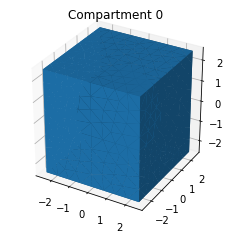

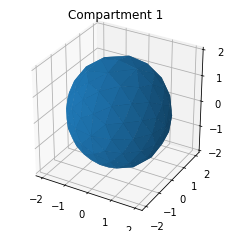

In [43]:
if 1==2:
  # mesh_name = "multi_layered_disk"

  # mesh_name = "CircleInSquare"

  mesh_name = "SphereInBox"

  # mesh_name = "multi_layered_cylinder"

  !rm -rf *
  !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/GetPartitionMarkers.py
  !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/$mesh_name''.geo

  !sed -i 's/5, 7.5, 10, 13/5, 7.5, 10/g' $mesh_name''.geo
  # !sed -i 's/lc = 1/lc = 0.5/g' $mesh_name''.geo

  !apt-get install gmsh

  !gmsh -3 $mesh_name''.geo -o $mesh_name''.msh
  !dolfin-convert $mesh_name''.msh $mesh_name''.xml

  mesh = Mesh(mesh_name+".xml");  
  
  clear_output()
  
  from GetPartitionMarkers import *

  partion_list=GetPartitionMarkers(mesh_name+".msh", "pmk_"+mesh_name+".xml")

  partition_marker = MeshFunction("size_t", mesh, mesh.topology().dim())

  File("pmk_"+mesh_name+".xml")>>partition_marker

  cmpt_mesh = SubMesh(mesh, partition_marker, 0)


'''
!rm -rf *
!wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/comri/meshes/multi_layer_torus.xml.zip
!wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/comri/meshes/multi_layer_torus_compt1.xml.zip
!unzip -q multi_layer_torus.xml.zip
!unzip -q multi_layer_torus_compt1.xml.zip
!rm -rf *.zip *MACOSX

# Load multilayered torus mesh and submesh
mesh = Mesh("multi_layer_torus.xml");  
cmpt_mesh = Mesh('multi_layer_torus_compt1.xml')

'''

if 1==1:
  mesh_name = "SphereInBox"
  !rm -rf *
  !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/$mesh_name''.msh.zip
  !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/$mesh_name''_cmpt.msh.zip
  
  !unzip -q $mesh_name''.msh.zip
  !unzip -q $mesh_name''_cmpt.msh.zip

  !apt-get install gmsh

  !dolfin-convert $mesh_name''.msh $mesh_name''.xml
  !dolfin-convert $mesh_name''_cmpt.msh $mesh_name''_cmpt.xml
  mesh = Mesh(mesh_name+".xml");  
  cmpt_mesh = Mesh(mesh_name+"_cmpt.xml");


  

V_DG = FunctionSpace(mesh, 'DG', 0)
dofmap_DG = V_DG.dofmap()
phase = Function(V_DG)
cellmarker = MeshFunction("size_t", mesh, mesh.topology().dim())

for cell in cells(mesh):
    p = cell.midpoint();
    is_in_cmpt = cmpt_mesh.bounding_box_tree().compute_first_entity_collision(p)<4294967295
    phase.vector()[dofmap_DG.cell_dofs(cell.index())] = is_in_cmpt;
    cellmarker[cell.index()] = is_in_cmpt;

mydomain = MyDomain(mesh, phase)      
    
# plot(phase, cmap="coolwarm");
mesh0 = SubMesh(mesh, cellmarker, 0)
mesh1 = SubMesh(mesh, cellmarker, 1)
File("Phase.pvd")<<phase
File("mesh0.xml")<<mesh0
File("mesh1.xml")<<mesh1
plt.figure(2); plot(mesh0, title="Compartment 0"); 
plt.figure(3); plot(mesh1, title="Compartment 1")  



# Solve the Bloch-Torrey equation

t: 0.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 0.00%
t: 2000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 9.80%
t: 4000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 19.61%
t: 6000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 29.41%
t: 8000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 39.22%
t: 10000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 49.02%
t: 12000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 58.82%
t: 14000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 68.63%
t: 16000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 78.43%
t: 18000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 88.24%
t: 20000.000000  T: 20000.0 dt: 400.0 gnorm: 3.872983e-05 Completed 98.04%
Elapsed time: 63.162543 seconds
b: 1000 Signal: 5.584e-02 kappa: 1.000e-01 , dt:  400 , hmin:  0.4239694427581647 , Free signal: 4.979e-02
Signal on each compartment
Signal0: 5.535e-02


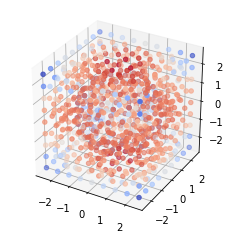

In [44]:
def InitialCondition(mydomain, V, W):
  if mydomain.gdim==2:
    Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]<eps",eps=1e6, domain=mydomain.mesh, degree=1);
  if mydomain.gdim==3:
    Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]+x[2]*x[2]<eps",eps=1e6, domain=mydomain.mesh, degree=1);
  Dirac_Delta = interpolate(Dirac_Delta, V);
  u_0 = Function(W);
  assign(u_0.sub(0), Dirac_Delta)
  assign(u_0.sub(2), Dirac_Delta)  
  return Dirac_Delta, u_0


class PeriodicBD(SubDomain):

    def __init__(self, mydomain, **kwargs):
        self.xmin, self.ymin, self.zmin = mydomain.xmin, mydomain.ymin, mydomain.zmin
        self.xmax, self.ymax, self.zmax = mydomain.xmax, mydomain.ymax, mydomain.zmax
        self.gdim = mydomain.gdim
        self.PeriodicDir = mydomain.PeriodicDir
        self.tol = 1e-2*mydomain.mesh.hmin()
        super().__init__(**kwargs)
    
    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        # return True if on left or bottom boundary AND NOT on one of the two corners (0, 1) and (1, 0) 
        bcx = abs(x[0] - self.xmin)<self.tol and self.PeriodicDir[0] == 1
        bcy = abs(x[1] - self.ymin)<self.tol and self.PeriodicDir[1] == 1
        bcz = 0
        if (self.gdim==3):
          bcz = abs(x[2] - self.zmin) < self.tol and self.PeriodicDir[2] == 1
          
        return bool((bcx or bcy or bcz) and on_boundary)

    def map(self, x, y):
        Lxx, Lyy, Lzz = 0, 0, 0
        if self.PeriodicDir[0] == 0:
          Lxx = 1e7;
        if self.PeriodicDir[1] == 0:
          Lyy = 1e7;
        if self.PeriodicDir[2] == 0:
          Lzz = 1e7;
          
        if abs(x[0] - self.xmax) < self.tol and self.PeriodicDir[0] == 1:
            y[0] = x[0] - (self.xmax - self.xmin) + Lxx
            y[1] = x[1]
            if (self.gdim==3):
              y[2] = x[2]
        elif abs(x[1] - self.ymax) < self.tol and self.PeriodicDir[1] == 1:
            y[0] = x[0]
            y[1] = x[1] - (self.ymax-self.ymin) + Lyy 
            if (self.gdim==3):
              y[2] = x[2]
        elif (self.gdim==3) and abs(x[2] - self.zmax)<self.tol and self.PeriodicDir[2] == 1:
            y[0] = x[0]
            y[1] = x[1]
            y[2] = x[2] - (self.zmax-self.zmin) + Lzz 
        else:
            y[0] = x[0] - (self.xmax-self.xmin) + Lxx
            y[1] = x[1] - (self.ymax-self.ymin) + Lyy
            if (self.gdim==3):
              y[2] = x[2] - (self.zmax-self.zmin) + Lzz

class MRI_parameters():
    def __init__(self):
      self.bvalue = 0
      self.gdir = None
      self.stype=''
      self.Delta = 0
      self.delta = 0
      self.T = 0
mparameters = MRI_parameters()



# fn = FacetNormal(mesh);
# fn0 = ieval(fn, 0, phase);

#################################################################################
#########################  Pre-defined parameters ###############################
mparameters.bvalue = 1000;                                  # bvalue
mparameters.delta, mparameters.Delta = 10000, 10000         # Time sequence
mparameters.gdir = Point(0, 0, 1);               # gradient direction
mparameters.gdir /=mparameters.gdir.norm()
mydomain.PeriodicDir = [0, 0, 1];   # Direction of the periodicity
mydomain.IsDomainPeriodic = False    # Confirm if the mesh if periodic
theta = 0.5;                        # theta=0.5: midpoint method
K = 3e-3;                           # Diffusion coefficient
mydomain.kappa = 1e-1               # Permeability
nskip = 5;                          # Output frequency (for visualization only)
porder = 1;                         # order of basis functions of FEM
Nsteps = 200;                       # number of time intervals
mparameters.nperiod = 0;
mparameters.stype='PGSE'                        # Sequence type
t, mparameters.T = 0, mparameters.Delta+mparameters.delta;
k = 400; # Time-step size
#################################################################################
#################################################################################
    
mparameters.gnorm = b2g(mparameters.bvalue, mparameters.delta, mparameters.Delta, mparameters.nperiod, mparameters.stype)


#################################
## output files 
file_u0r = File("results/u0r.pvd")
file_u0i = File("results/u0i.pvd")
file_u1r = File("results/u1r.pvd")
file_u1i = File("results/u1i.pvd")
#################################

#################################################################################
# FUNCTION SPACES

if (mydomain.IsDomainPeriodic==True):
    periodicBD = PeriodicBD(mydomain) 
    Ve, V, W = MyFunctionSpaces(mesh, porder, periodicBD)
else:
    Ve, V, W = MyFunctionSpaces(mesh, porder)

v = TestFunction(W)
w = TrialFunction(W);

Dirac_Delta, u_0 = InitialCondition(mydomain, V, W)



stepcounter = 0;

wpperiodic = WeakPseudoPeriodic_2c(mydomain, mparameters, degree=1)

h = 0.5*CellDiameter(mesh);

if mydomain.gdim==2:
    mydomain.kappa_e = K/h*Expression("(x[0]<xmin+eps || x[0]>xmax-eps)*p0+(x[1]<ymin+eps || x[1]>ymax-eps)*p1", 
                         xmin=mydomain.xmin, xmax=mydomain.xmax, ymin=mydomain.ymin, ymax=mydomain.ymax, 
                         eps=1e-10, p0 = mydomain.PeriodicDir[0], p1 = mydomain.PeriodicDir[1], domain=mesh, degree=1);
    mparameters.g = Expression(("g0","g1"), g0=mparameters.gdir.x(), g1=mparameters.gdir.y(),domain=mesh,degree=1);

if mydomain.gdim==3:
    mydomain.kappa_e = K/h*Expression("(x[0]<xmin+eps || x[0]>xmax-eps)*p0+(x[1]<ymin+eps || x[1]>ymax-eps)*p1+(x[2]<zmin+eps || x[2]>zmax-eps)*p2", 
                         xmin=mydomain.xmin, xmax=mydomain.xmax, ymin=mydomain.ymin, ymax=mydomain.ymax, zmin=mydomain.zmin, zmax=mydomain.zmax, 
                         eps=1e-10, p0 = mydomain.PeriodicDir[0], p1 = mydomain.PeriodicDir[1], p2 = mydomain.PeriodicDir[2], domain=mesh, degree=1);
    mparameters.g = Expression(("g0","g1","g2"), g0=mparameters.gdir.x(), g1=mparameters.gdir.y(), g2=mparameters.gdir.z(),domain=mesh,degree=1);
    
# M, J, S, I, II = NoTimeMatrices(w, v, K, gdir, kappa, kappa_e, theta, phase);

M = MassMatrix2c(w, v, phase);


solver = PETScLUSolver("mumps")




ft_prev  =  time_profile(t, mparameters.delta, mparameters.Delta, mparameters.stype);
ift_prev = itime_profile(t, mparameters.delta, mparameters.Delta, mparameters.stype);

start_time = time.time()

while t < mparameters.T + k: # Time-stepping loop
    if stepcounter % nskip == 0:
        print('t: %f '%t, 'T: %.1f'%mparameters.T, 'dt: %.1f'%k,'gnorm: %e'%mparameters.gnorm,'Completed %.2f%%'%(float(t)/float(mparameters.T+k)*100.0));

    ft = time_profile(t, mparameters.delta, mparameters.Delta, mparameters.stype);
    ift = itime_profile(t, mparameters.delta, mparameters.Delta, mparameters.stype);

    if (mydomain.IsDomainPeriodic==True):
        L = ThetaMethodL_sBC2c(ft_prev, ift_prev, mparameters, w, v ,u_0, k, K, theta, phase, mydomain, wpperiodic);
        A = 1/k*M + assemble(ThetaMethodF_sBC2c(ft, ift, mparameters, w, v, k, K, theta, phase, mydomain))
    else:
        L = ThetaMethodL_wBC2c(ft_prev, ift_prev, mparameters, w, v ,u_0, k, K, theta, phase, mydomain, wpperiodic);
        A = 1/k*M + assemble(ThetaMethodF_wBC2c(ft, ift, mparameters, w, v, k, K, theta, phase, mydomain))
    
    b = assemble(L);

    solver.solve(A,u_0.vector(),b);
        
    ft_prev  = ft;
    ift_prev = ift;
    
    t += k;
    stepcounter += 1;
    
elapsed_time = time.time() - start_time
print("Elapsed time: %f seconds"%elapsed_time)




# Post-processing

u0r_0, u0i_0, u1r_0, u1i_0 = split(u_0)

signal0 = assemble(((1-phase)*u0r_0)*dx)/assemble((1-phase)*Dirac_Delta*dx);
signal1 = assemble((phase*u1r_0)*dx)/assemble(phase*Dirac_Delta*dx);
signal = assemble((phase*u1r_0+(1-phase)*u0r_0)*dx)/assemble(Dirac_Delta*dx);

print('b:',mparameters.bvalue, 'Signal: %.3e'%signal,'kappa: %.3e'%mydomain.kappa,', dt: ',k,', hmin: ',mydomain.hmin, ', Free signal: %.3e'%(exp(-mparameters.bvalue*K)))

print('Signal on each compartment')
print('Signal0: %.3e'%signal0)
print('Signal1: %.3e'%signal1)

V0 = FunctionSpace(mesh0,Ve);
V1 = FunctionSpace(mesh1,Ve);
u0r_0p = project(u0r_0,V0)
u1r_0p = project(u1r_0,V1)
plot(u0r_0p, cmap="coolwarm")
plot(u1r_0p, cmap="coolwarm")

# Reference solutions

In [0]:
# The results were generated by the Matrix Formalism method propsed in
# D.S. Grebenkov, Pulsed-gradient spin-echo monitoring of restricted 
# diffusion in multilayered structures, J. Magn. Reson., 205 (2) (2010)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # R=[5,7.5,10], kappa=5e-5m/s delta=Delta=40000
#  bvalue  # signal attenuation
# # # # # # # # # # # # # # #
# # # # # # # # # # # # # # #